# Modeling damage grade 

In this notebook we begin our modeling work for identifying the best model that accurately predicts the damage grade for buildings based on their features.

Game Plan:
- We will use RMSE as our metric for model evaluation (we have moved from a classification model to a regression model since out target is ordinal)
- We will use stratified sampling of our target variable in the training data so as to have equal representation of all the 3 damage grades.
- We will then begin modeling with cross-validation and use the validation set to test each model.
- The model with least RMSE score will then be chosen as our ideal model for predicting the damage grade of buildings


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

### Bring in the data 

In [3]:
df = cfs.cleaned_dataframe()

In [4]:
print(df.shape)
df.head()

(762093, 39)


,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,target
building_id,,,,,,,,,,,,,,,,,,,,,
120101000011,12,1207,120703,1,9,288,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,2.0
120101000021,12,1207,120703,1,15,364,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,3.0
120101000031,12,1207,120703,1,20,384,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000041,12,1207,120703,1,20,312,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0
120101000051,12,1207,120703,1,30,308,9,flat,other,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,1.0


In [5]:
y = df['target']
X = df.drop('target', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2015, test_size = .2)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 2015, test_size = .25)

In [7]:
len(X_tr)

457255

In [8]:
len(y_tr)

457255

In [9]:
Xy_concated = pd.concat([y_tr, X_tr], axis=1)

In [10]:
print(Xy_concated.shape)
Xy_concated.head()

(457255, 39)


,target,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
314006030291,2.0,31,3102,310204,2,22,280,14,flat,bamboo_or_timber,...,0,1,0,0,0,0,0,0,0,0
214609000051,3.0,21,2106,210605,2,25,200,14,flat,mud_mortar_stone_or_brick,...,0,0,0,0,0,0,0,0,0,0
303205001021,3.0,30,3009,300909,3,30,265,16,flat,mud_mortar_stone_or_brick,...,0,0,0,0,0,0,0,0,0,0
230604002521,3.0,23,2302,230203,2,25,1000,16,flat,mud_mortar_stone_or_brick,...,0,0,0,0,0,0,0,0,0,0
241108000891,3.0,24,2413,241304,3,9,435,20,flat,mud_mortar_stone_or_brick,...,0,0,0,0,0,0,0,0,0,0


Since we do have class imbalance in our dataset we will manually resample the training data to have balanced representation of the target.

In [11]:
Xy_1 = Xy_concated[Xy_concated.target == 1.0]
Xy_2 = Xy_concated[Xy_concated.target == 2.0]
Xy_3 = Xy_concated[Xy_concated.target == 3.0]

In [12]:
print(len(Xy_1))
print(len(Xy_2))
print(len(Xy_3))

99708
81857
275690


This distribution of target looks highly imbalanced, majority belong to damage_grade 3.
There's an imbalance-learn undersampling method called `RandomUnderSampler` that helps achieve our objective of getting a balanced class distribution without adding synthetic datapoints. 

In [13]:
rus = RandomUnderSampler(random_state=2015)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)

Now that we have balanced classes we can go ahead with OneHotEncoding the training data first and use the encoders to transform the validation and testing sets.

In [14]:
X_tr, X_val, X_test = pfs.ohe_train_and_test_features(X_tr_res, X_val, X_test)

## Modeling

We start our modeling with `DecisionTreeRegressor`

In [16]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

In [23]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def scorer():
    scorer = make_scorer(rmse)
    return scorer

scorer = scorer()

In [26]:
dtr = DecisionTreeRegressor(random_state=2015)
dtr.fit(X_tr, y_tr_res)
cross_val_score(dtr, X_tr, y_tr_res, scoring=scorer, cv=3)

array([1.29860535, 0.99739633, 1.30812897])

In [27]:
rmse(y_val, dtr.predict(X_val))

0.7826164747329428

In [28]:
rmse(y_tr_res, dtr.predict(X_tr))

0.07278995206306142

the Decision Tree Regressor has high variance when we compare results between the training and validation sets. We need to bring in some randomness to combat that.

We'll first try Random Forest classifier and see if that helps lower the variance between training and validation sets. 

In [29]:
from sklearn.tree import plot_tree

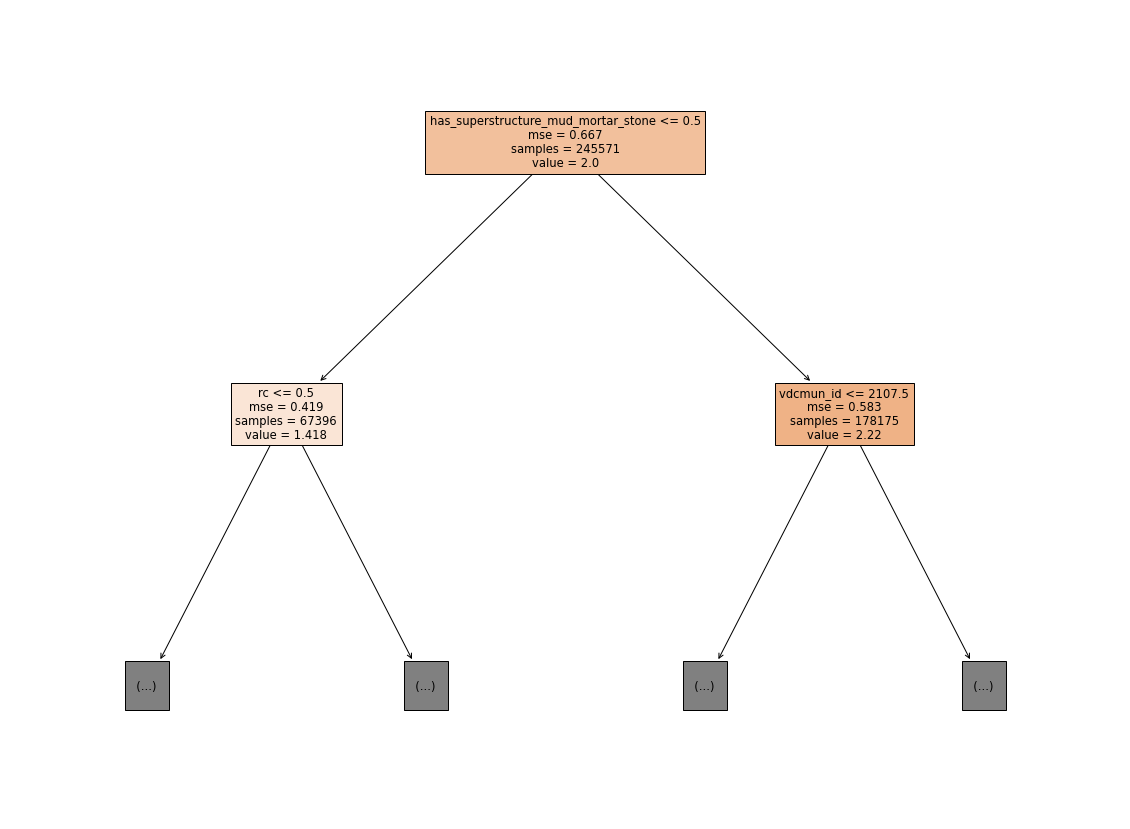

In [34]:
plt.figure(figsize=(20,15))
plot_tree(dtr, feature_names=X_tr.columns, filled=True, max_depth=1)
plt.show()

In [35]:
rfr1 = RandomForestRegressor(random_state=2015)
cross_val_score(rfr1, X_tr, y_tr_res, scoring=scorer, cv=3)

array([1.24520422, 0.66127361, 1.26197426])

this model took about 7 minutes to run! and there's some variation in the 3 folds. I feel normalizing the data and PCA can help in decreasing teh computayional complexity for fututre models. Let's use standard scaler and standardize the numeric columns. Also, we have three columns relating to geographic location, we must do some eda relating to target and these columns and see which of these gives us the most information. We could treat them as categorical columns too since they are just ids really, Le't look into that real quick.

In [36]:
X_train

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
310807000141,31,3103,310305,2,18,285,22,flat,mud_mortar_stone_or_brick,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,0
243603000621,24,2408,240812,3,13,320,18,flat,mud_mortar_stone_or_brick,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,0
246101000361,24,2404,240402,1,7,375,11,flat,mud_mortar_stone_or_brick,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,0
220609000531,22,2208,220802,2,30,448,16,flat,mud_mortar_stone_or_brick,bamboo_or_timber_heavy_roof,...,0,0,0,0,0,0,0,0,0,0
210905000221,21,2105,210510,3,30,370,20,moderate_slope,mud_mortar_stone_or_brick,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214709001361,21,2102,210203,2,10,209,18,flat,mud_mortar_stone_or_brick,bamboo_or_timber_heavy_roof,...,0,0,0,0,0,0,0,0,0,0
234102000831,23,2311,231108,3,12,337,21,moderate_slope,mud_mortar_stone_or_brick,bamboo_or_timber_heavy_roof,...,0,0,0,0,0,0,0,0,0,0
313609000621,31,3101,310103,2,16,543,16,flat,mud_mortar_stone_or_brick,bamboo_or_timber_light_roof,...,0,0,0,0,0,0,0,0,0,0


In [37]:
y_train

building_id
310807000141    2.0
243603000621    3.0
246101000361    2.0
220609000531    2.0
210905000221    3.0
               ... 
214709001361    3.0
234102000831    3.0
313609000621    2.0
203905000761    1.0
222606002691    2.0
Name: target, Length: 609674, dtype: float64

In [38]:
data = pd.concat([y_train, X_train], axis =1)

In [41]:
data.groupby('district_id').target.value_counts(sort=False)

district_id  target
12           1.0       13310
             2.0        7328
             3.0       10873
20           1.0       22048
             2.0       13673
             3.0       19302
21           1.0        7438
             2.0       13594
             3.0       25785
22           1.0        3496
             2.0        5195
             3.0       39802
23           1.0        2624
             2.0        2623
             3.0       65650
24           1.0       16101
             2.0       20038
             3.0       42262
28           1.0        4285
             2.0        6598
             3.0       50915
29           1.0         489
             2.0         638
             3.0        8955
30           1.0        9980
             2.0       12216
             3.0       49143
31           1.0       42794
             2.0       14945
             3.0       15044
36           1.0       10261
             2.0       12418
             3.0       39851
Name: target, dtype: in

In [49]:
def plot_relation_with_target(name, df):
    """ Given a feature name and the df, this function plots out
    a bargraph for the relation between feature and  the target
    with regards to the count
    This works for numbered categorical data
    """
    
    plt.figure(figsize=(20,8))

    counts = df.groupby([name]).target.value_counts(sort=False)

    sns.barplot(x=counts.index, y=counts, palette=['#1AC7C4', 'teal', '#95190C'])
    
    #setting the labels here
    plt.tick_params(axis='x', labelrotation=90, labelsize=15)
    plt.xlabel(name.capitalize(), fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    plt.tight_layout()
    
    return plt.show()

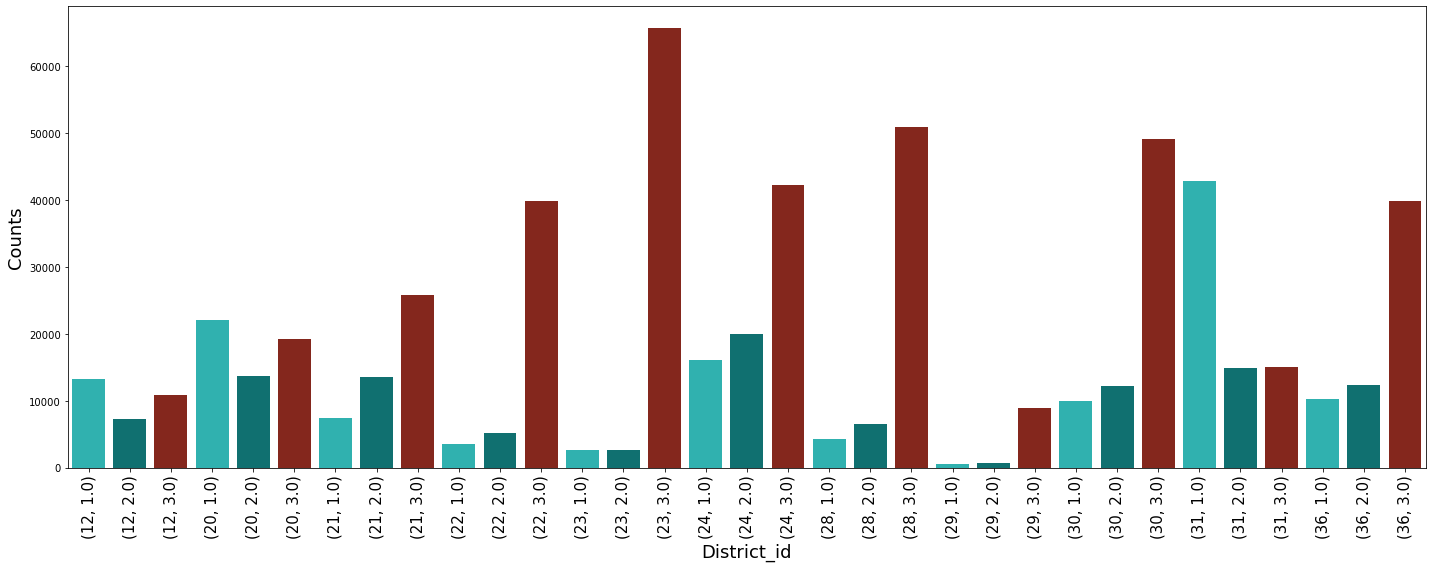

In [50]:
plot_relation_with_target('district_id', data)

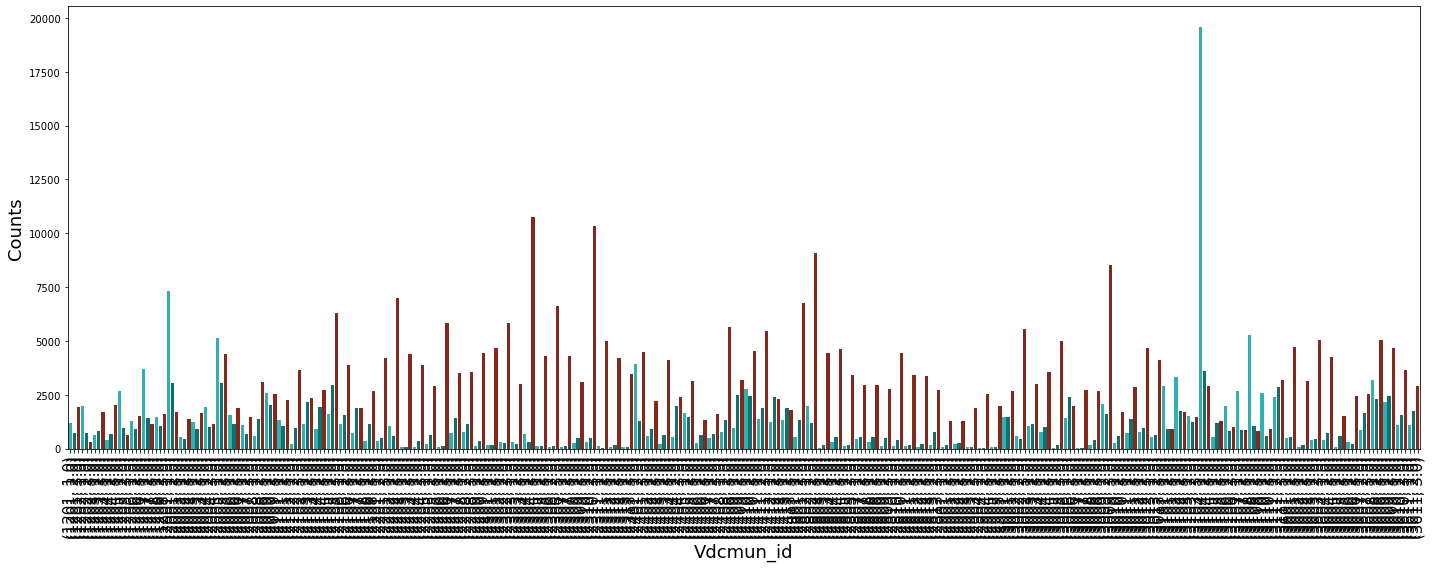

In [51]:
plot_relation_with_target('vdcmun_id', data)

In [48]:
data.vdcmun_id.unique().shape

(110,)

In [47]:
data.ward_id.unique().shape

(945,)

In [52]:
str_df, own_df, ward_df = cfs.load_raw_files()

In [56]:
district_id = ward_df.district_id.unique()

In [64]:
for i in district_id:
    print(i, ward_df[ward_df['district_id'] == i].district_name.unique())

12 ['Okhaldhunga']
20 ['Sindhuli']
21 ['Ramechhap']
22 ['Dolakha']
23 ['Sindhupalchok']
24 ['Kavrepalanchok']
28 ['Nuwakot']
29 ['Rasuwa']
30 ['Dhading']
31 ['Makwanpur']
36 ['Gorkha']


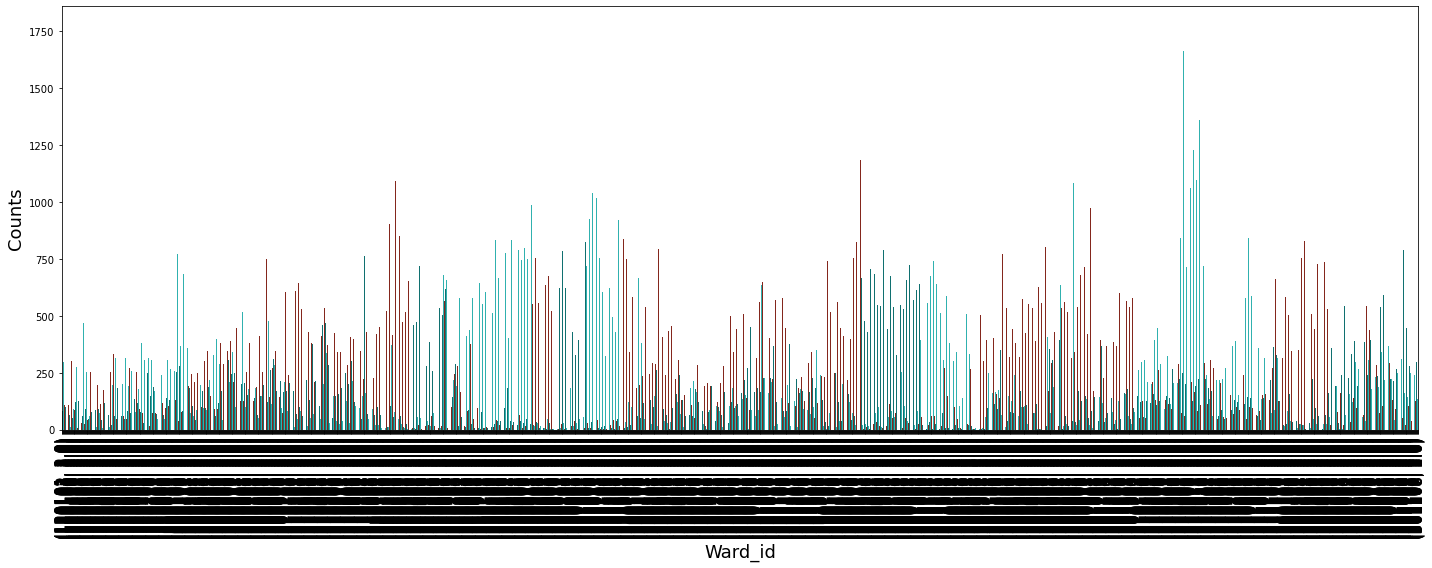

In [65]:
plot_relation_with_target('ward_id', data)

The more granular we get with the regions from district -> to municipality -> to ward, from the above visualiztions we can observe that there are some regions that were able to handle the effects of the earthquake better than the others. We are now faced with two issues a) computational complexity issue, b) treatment of these region ids as numeric issue. 

Here's one strategy- what if we use the districts and municipality columns as categorical and ohe them. we will drop ward and see if we can run a better random forest (both rmse and computation time will be checked to determine if this works better)

In [66]:
def one_hot_encode_geos(df, name):
    """This funciton takes in a dataframe and a feature name and 
    One hot encodes the feature and adds it to the dataframe
    
    Returns transformed dataframe and the ohe object 
    used to transform the frame
    """
    
    ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')
    single_feature_df = df[[name]]
    ohe.fit(single_feature_df)
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=df.index)
    df = df.drop(name, axis=1)
    df = pd.concat([df, ohe_df], axis=1)
    
    #returning ohe here so that it can be used to transform X_test later
    return df, ohe

def ohe_all_categorical_geos(df):
    """This function takes in a dataframe, identifies the
    dtypes in the dataframe and uses the object dtypes to
    list out categorical columns
    
    Next it use OneHotEncoder to convert those Categorical 
    features
    
    Returns: the transformed dataframe and a dictionary 
    containing the ohe object that can be used later to 
    transform the testing dataset
    """
    categorical_feats = ['district_id', 'vdcmun_id']
    #use helper function in loop to transform dataframe
    encoders = {}
    
    for name in categorical_feats:
        df, ohe = one_hot_encode_geos(df, name)
        encoders[name] = ohe
    
    return df, encoders

def one_hot_encode_test_geos(df, name, ohe):
    """This funciton takes in the test dataframe, a feature name and 
    an ohe object and then One hot encodes the feature and adds
    it to the dataframe
    
    Returns the transformed test dataframe
    """
    
    single_feature_df = df[[name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=df.index)
    df = df.drop(name, axis=1)
    df = pd.concat([df, ohe_df], axis=1)
    
    return df

def ohe_train_val_test_geos(X_train, X_val, X_test):
    """This function takes in the train, validation and test sets.
    OneHotEncodes the features on train and transforms the 
    validation and test set with extracted encoders"""
    
    X_train, encoders = ohe_all_categorical_geos(X_train)
    
    for key in encoders:
        X_test = one_hot_encode_test_geos(X_test, key, encoders[key])
        X_val = one_hot_encode_test_geos(X_val, key, encoders[key])
    
    return X_train, X_val, X_test


In [68]:
X_tr, X_val, X_test = ohe_train_val_test_geos(X_tr, X_val, X_test)

In [69]:
X_tr

,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611
0,210605,1,52,150,8,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,310205,1,15,186,8,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,360306,2,7,392,12,0,1,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,361003,2,17,496,12,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,310108,2,24,305,18,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245566,230401,2,18,304,12,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245567,280401,2,20,280,16,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245568,290206,1,2,450,8,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245569,280208,1,5,250,7,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

X_train_scaled = X_tr.copy().drop('ward_id', axis=1)
col_names = ['count_floors_pre_eq', 'age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']
features = X_train_scaled[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X_train_scaled[col_names] = features
X_train_scaled.head()


,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611
0,-1.536583,0.442693,-1.098342,-1.386090,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.536583,-0.120057,-0.952638,-1.386090,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.047621,-0.241732,-0.118883,-0.686274,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.047621,-0.089638,0.302041,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.047621,0.016828,-0.471003,0.363450,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
X_val_scaled = X_val.copy().drop('ward_id', axis=1)
X_test_scaled = X_test.copy().drop('ward_id', axis=1)
features = X_val_scaled[col_names]
features = scaler.transform(features.values)
X_val_scaled[col_names] = features
features = X_test_scaled[col_names]
features = scaler.transform(features.values)
X_test_scaled[col_names] = features


In [89]:
X_train_scaled.head(3)

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611
0,-1.536583,0.442693,-1.098342,-1.386090,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.536583,-0.120057,-0.952638,-1.386090,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.047621,-0.241732,-0.118883,-0.686274,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
X_val_scaled.head(3)

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611
building_id,,,,,,,,,,,,,,,,,,,,,
366409000591,-0.047621,0.108085,0.399178,0.538404,0,1,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
302306002231,-0.047621,-0.256942,1.734804,-0.686274,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283907000681,-0.047621,0.488321,-0.248399,1.063266,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
X_test_scaled.head(3)

,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,...,3602,3603,3604,3605,3606,3607,3608,3609,3610,3611
building_id,,,,,,,,,,,,,,,,,,,,,
231604000321,1.441341,-0.180895,-0.050078,0.888312,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362809000701,-1.536583,-0.120057,-0.337440,-0.511320,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
202807000381,-0.047621,-0.196104,0.107768,-0.336366,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
rfr2 = RandomForestRegressor(random_state=2015)
cross_val_score(rfr2, X_train_scaled, y_tr_res, scoring=scorer, cv=3)

array([1.24917071, 0.64587546, 1.26373113])

That took 15 minutes to run! not a lot of difference from the previous set

In [94]:
rfr2.fit(X_train_scaled, y_tr_res)

RandomForestRegressor(random_state=2015)

In [95]:
rmse(y_tr_res, rfr2.predict(X_train_scaled))

0.2302527531773007

In [96]:
rmse(y_val, rfr2.predict(X_val_scaled))

0.6234370506625764

training rmse = 0.23, validation rmse = 0.623, there's still a high variance between the training and validation set, however there's a slight improvement from the decision tree regressor (training rmse 0.07, validation rmse 0.78, variance was too high between them)

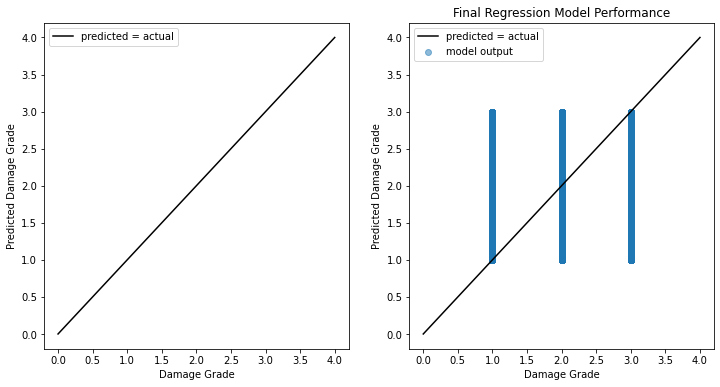

In [100]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

# Customize which model is actually being plotted
# axes[0].set_title("Baseline Regression Model Performance")
# axes[0].scatter(y_val, dtr.predict(X_val),
#                 alpha=0.5, label="model output", color="green")

axes[1].set_title("Final Regression Model Performance")
axes[1].scatter(y_val, rfr2.predict(X_val_scaled),
                alpha=0.5, label="model output")

# Same setup for both plots (x and y labels, line showing y=x)
y_equals_x = np.linspace(0, 4)
for ax in axes:
    ax.set_xlabel("Damage Grade")
    ax.set_ylabel("Predicted Damage Grade")
    ax.plot(y_equals_x, y_equals_x, label="predicted = actual", color="black")
    ax.legend()

In [101]:
predictions = rfr2.predict(X_val_scaled)

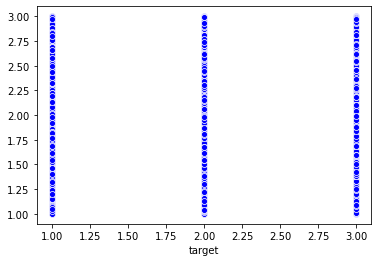

In [105]:
sns.scatterplot(y_val,predictions, color='blue')


In [111]:
import math
rounded_preds = []
for i in predictions:
    rounded_preds.append(math.ceil(i))

In [112]:
rounded_preds[:10]

[2, 3, 3, 3, 3, 3, 2, 3, 2, 3]

In [116]:
predictions[:10]

array([1.83      , 2.16      , 2.82      , 2.1125    , 2.27      ,
       3.        , 1.81166667, 2.83      , 1.48      , 2.83      ])

In [117]:
y_val[:10]

building_id
366409000591    1.0
302306002231    3.0
283907000681    3.0
290508020311    2.0
201404000311    2.0
237401000501    3.0
311204000471    3.0
221705000131    3.0
312505000241    1.0
300308000051    3.0
Name: target, dtype: float64

In [114]:
confusion_matrix(y_val, rounded_preds, normalize='true')

array([[4.79799505e-02, 8.08593514e-01, 1.43426535e-01],
       [2.29851509e-03, 4.90240432e-01, 5.07461053e-01],
       [2.82940844e-04, 1.46008358e-01, 8.53708702e-01]])

In [115]:
confusion_matrix(y_val, rounded_preds)

array([[ 1589, 26779,  4750],
       [   63, 13437, 13909],
       [   26, 13417, 78449]])

Regression method seems to predict class 2 more often than the other two classes, makes sense since it is the average. May be not pivot completely and stick with classification models. Work on making a scorer that penalizes missclassifiction of damage grade 3.